------------

> ❗❗❗⚠️  💸   DONT USE GPU❗❗❗   
> **🧠 🤑   USE ONLY CPU (max GB used: RAM 3 - DISC 30 )**
------------

### Introducción

En este notebook, llevaremos a cabo el entrenamiento y la evaluación de varios modelos de clasificación para la detección de fraudes utilizando un conjunto de datos de transacciones financieras.
Comenzaremos cargando y preprocesando los datos de entrenamiento y prueba, eliminando columnas irrelevantes y codificando variables categóricas.
Posteriormente, escalaremos las características numéricas para garantizar que todos los modelos se entrenen de manera uniforme. Utilizaremos técnicas de validación cruzada para evaluar el rendimiento de varios modelos, incluyendo Random Forest, Logistic Regression (LASSO), K-Nearest Neighbors, Decision Tree, Support Vector Machine y Gradient Boosting. El modelo con el mejor rendimiento se ajustará con los hiperparámetros óptimos utilizando GridSearchCV.

Una vez entrenados y evaluados los modelos, procederemos a calcular y visualizar métricas importantes como la matriz de confusión, curvas de precisión-recall, RMSE y MAE tanto para los datos de entrenamiento como para los datos de prueba.
Finalmente, guardaremos el modelo entrenado y los resultados en archivos locales, y subiremos estos archivos a una carpeta compartida en Google Drive. Este proceso garantiza que los modelos y resultados estén accesibles para su posterior análisis y uso en un servidor de MLFlow, facilitando la colaboración y el seguimiento de experimentos en un entorno de machine learning.

In [ ]:
# Instalamos las librerías necesarias
!pip install --upgrade -q google-api-python-client google-auth-httplib2 google-auth-oauthlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 46.5 MB/s eta 0:00:00


In [ ]:
!pip install -q gdown

In [ ]:
# Agregamos todos las librerías base con las que vamos a trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.linear_model as lm
import pickle
import gdown
import os
import google.auth
import joblib
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from google.colab import drive
from google.colab import auth
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

%matplotlib inline

Tras haber finalizado el análisis exploratorio del dataset, generamos el pipeline del proyecto con el fin de poder aplicar los cambios más facilmente a test.

In [ ]:
auth.authenticate_user()

In [ ]:
# URL de la carpeta compartida
folder_url = 'https://drive.google.com/drive/folders/1Ihit8ngHtsKlykuF51xXFWMa8k7oYw_D?usp=sharing'

In [ ]:
# Extraemos el ID de la carpeta
folder_id = folder_url.split('/')[-1].split('?')[0]

In [ ]:
# Listamos los archivos en la carpeta usando gdown
!gdown --folder {folder_id}

Retrieving folder contents
Processing file 1q896oVJpS8jvEQGUN7N1aH_qmuSOfiwM fraude_test.csv
Processing file 1rUWWXxfGpKJuyOKelTu2bZO5Y7_klqie fraude_train.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1q896oVJpS8jvEQGUN7N1aH_qmuSOfiwM
To: /content/FraudDetection_EDA/fraude_test.csv
100% 2.45M/2.45M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rUWWXxfGpKJuyOKelTu2bZO5Y7_klqie
To: /content/FraudDetection_EDA/fraude_train.csv
100% 9.78M/9.78M [00:00<00:00, 32.9MB/s]
Download completed


In [ ]:
file_name_train = '/content/FraudDetection_EDA/fraude_train.csv'
file_name_test = '/content/FraudDetection_EDA/fraude_test.csv'

In [ ]:
# Cargamos el dataset usando pandas
df_train = pd.read_csv(file_name_train, sep=';', decimal='.')
df_test = pd.read_csv(file_name_test, sep=';', decimal='.')

In [ ]:
# Mostramos las primeras filas del dataframe para verificar que se ha cargado correctamente
print(df_train.head())
print(df_test.head())

   Unnamed: 0 trans_date_trans_time        cc_num  \
0       39748          1/24/19 6:25  3.607810e+13   
1        5412          1/4/19 13:10  4.755700e+12   
2       19160         1/12/19 16:27  2.131260e+14   
3       19682         1/12/19 23:31  3.764450e+14   
4       41904         1/25/19 21:59  3.858050e+13   

                           merchant        category     amt        first  \
0             fraud_Vandervort-Funk     grocery_pos  126.10  Christopher   
1  fraud_Zemlak, Tillman and Cremin   personal_care    4.57       Robert   
2          fraud_Romaguera and Sons          travel    2.41         Adam   
3                 fraud_Kilback LLC     food_dining   47.33       Rachel   
4              fraud_Hamill-D'Amore  health_fitness   45.80       Teresa   

    last gender                         street  ...      lat      long  \
0   Horn      M            956 Sanchez Highway  ...  37.2692  -82.9161   
1  Evans      M  01892 Patricia Vista Apt. 828  ...  32.9643  -96.6012   
2 

In [ ]:
#Eliminamos las columnas de tipo object
df_train= df_train.drop(['first', 'last','gender','street','city','state','trans_num','job', 'dob','trans_date_trans_time'], axis=1)

# Convertimos cc_num a tipo int para eliminar la notación científica
df_train['cc_num'] = df_train['cc_num'].astype(int)

#Eliminamos las columnas tipo numéricas
df_train= df_train.drop(['Unnamed: 0', 'zip','city_pop'], axis=1)

# Codificamos las variables
le_merchant = LabelEncoder()
le_category = LabelEncoder()
df_train['merchant'] = le_merchant.fit_transform(df_train['merchant'])
df_train['category'] = le_category.fit_transform(df_train['category'])

# Comprobamos que todo se ha aplicado correctamente
print(df_train.shape)
df_train.head(5)

(38438, 10)


,cc_num,merchant,category,amt,lat,long,unix_time,merch_lat,merch_long,is_fraud
0,36078100000000,645,4,126.10,37.2692,-82.9161,1327386350,37.429749,-82.828426,0
1,4755700000000,689,10,4.57,32.9643,-96.6012,1325682657,33.062253,-97.423714,0
2,213126000000000,527,13,2.41,42.0740,-74.4530,1326385629,43.053188,-74.149802,0
3,376445000000000,316,1,47.33,41.1558,-101.1360,1326411078,42.155397,-101.537459,0
4,38580500000000,226,5,45.80,48.8856,-103.0098,1327528776,49.460141,-102.638408,0


Aplicamos los cambios a test

In [ ]:
#Eliminamos las columnas de tipo object
df_test= df_test.drop(['first', 'last','gender','street','city','state','trans_num','job', 'dob','trans_date_trans_time'], axis=1)

# Convertimos cc_num a tipo int para eliminar la notación científica
df_test['cc_num'] = df_test['cc_num'].astype(int)

#Eliminamos las columnas tipo numéricas
df_test= df_test.drop(['Unnamed: 0', 'zip','city_pop'], axis=1)

# Codificamos las variables
le_merchant = LabelEncoder()
le_category = LabelEncoder()
df_test['merchant'] = le_merchant.fit_transform(df_test['merchant'])
df_test['category'] = le_category.fit_transform(df_test['category'])

# Comprobamos que todo se ha aplicado correctamente
print(df_test.shape)
df_test.head(5)

(9610, 10)


,cc_num,merchant,category,amt,lat,long,unix_time,merch_lat,merch_long,is_fraud
0,4116550000000000,197,7,166.80,27.2625,-80.3793,1325437607,27.704133,-80.623091,0
1,4335530000000000,170,1,12.52,38.3511,-91.4867,1325775929,38.535690,-92.208903,0
2,4225990000000000000,425,12,7.73,20.0827,-155.4880,1326961509,20.417444,-155.494826,0
3,3573030000000000,627,12,4.24,40.3207,-110.4360,1325598531,40.581180,-110.183785,0
4,4769430000000000000,284,12,1.75,40.5553,-77.4001,1325393326,41.166290,-78.109940,0


Distribución de fraudes no fraudes en train

In [ ]:
# Contamos la cantidad de registros fraudulentos y no fraudulentos
fraud_counts = df_train['is_fraud'].value_counts().reset_index()
fraud_counts.columns = ['is_fraud', 'count']

# Convertimos los valores de 'is_fraud' a etiquetas más comprensibles
fraud_counts['is_fraud'] = fraud_counts['is_fraud'].replace({0: 'No Fraude', 1: 'Fraude'})

# Calculamos los porcentajes
total_records = df_train.shape[0]
fraud_counts['percentage'] = (fraud_counts['count'] / total_records) * 100
print(fraud_counts)

    is_fraud  count  percentage
0  No Fraude  33645   87.530569
1     Fraude   4793   12.469431


Distribución de fraudes y no fraudes en test

In [ ]:
# Contamos la cantidad de registros fraudulentos y no fraudulentos
fraud_counts = df_test['is_fraud'].value_counts().reset_index()
fraud_counts.columns = ['is_fraud', 'count']

# Convertimos los valores de 'is_fraud' a etiquetas más comprensibles
fraud_counts['is_fraud'] = fraud_counts['is_fraud'].replace({0: 'No Fraude', 1: 'Fraude'})

# Calculamos los porcentajes
total_records = df_test.shape[0]
fraud_counts['percentage'] = (fraud_counts['count'] / total_records) * 100
print(fraud_counts)

    is_fraud  count  percentage
0  No Fraude   8397   87.377732
1     Fraude   1213   12.622268


In [ ]:
# creamos variables standard
x_features_train = df_train.drop(columns=['is_fraud'])
y_target_train = df_train['is_fraud']

x_features_test = df_test.drop(columns=['is_fraud'])
y_target_test = df_test['is_fraud']

In [ ]:
# Procedemos a escalar los datos tanto en Train como en Test, reutilizando el scaler entrenado en Train

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(x_features_train)
XtrainScaled = scaler.transform(x_features_train)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(x_features_test)

In [ ]:
print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (38438, 9)
Datos test:  (9610, 9)


In [ ]:
# Configuramos una semilla que va a ser utilizada para entrenar todos los modelos
global_seed = 42

# Creamos un array de modelos an entrenar
# Como va a ser una revisión general de modelos, no se pone mucho enfasis
# en configurar los diferentes parámetres
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=global_seed)))
models.append(("LASSO", lm.LogisticRegression(random_state=global_seed)))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=global_seed)))
models.append(("SVM", SVC(random_state=global_seed)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=global_seed)
))

# Creamos arrays para almacenar los resultados
results = []
names = []
fitted_models = []

# setemos en 0 los mejores resultados
best_mean_result = 0
best_std_result = 0

# Corremos todos los modelos utilizando StratifiedKFlod y cross_val_score
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, XtrainScaled, y_target_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 6)) + ", std(accuracy)=" + str(round(np.std(cv_results), 6)))
  model.fit(XtrainScaled, y_target_train)  # Entrenamos el modelo
  fitted_models.append((name, model))  # Guardamos el modelo entrenado

  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nEl mejor modelo es:\n" + best_model_name)

Random Forest: mean(accuracy)=0.996488, std(accuracy)=0.000411
LASSO: mean(accuracy)=0.987955, std(accuracy)=0.000911
KNN: mean(accuracy)=0.984859, std(accuracy)=0.001
Decision Tree: mean(accuracy)=0.994693, std(accuracy)=0.00069
SVM: mean(accuracy)=0.989776, std(accuracy)=0.000762
Gradient Boosting: mean(accuracy)=0.995161, std(accuracy)=0.000482

El mejor modelo es:
Random Forest


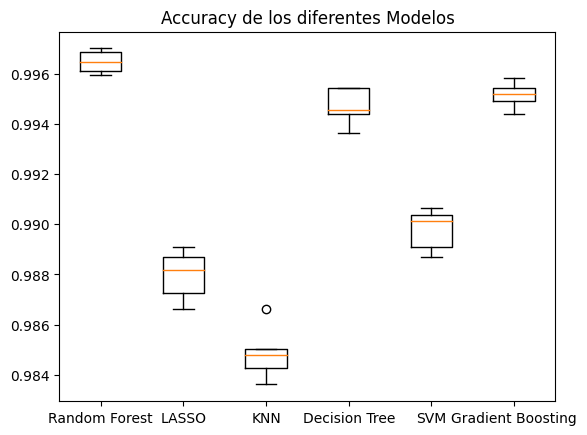

In [ ]:
plt.boxplot(results, labels=names)
plt.title("Accuracy de los diferentes Modelos")
plt.show()

In [ ]:
# modelo a entrenar
model = RandomForestClassifier()

# Elegimos algunos hiperparámetros para buscar el óptimo
params = {"n_estimators": range(10, 31, 3),
           "min_samples_split": range(2, 10, 2)}

# Entrenamos usando grid_search para encontrar los hiperparámetros óptimos
grid_search = GridSearchCV(model, params)
grid_search.fit(XtrainScaled, y_target_train)

print("El 'n_estimators' optimo es:", grid_search.best_params_["n_estimators"])
print("El 'min_samples_split' optimo es:", grid_search.best_params_["min_samples_split"])

El 'n_estimators' optimo es: 28
El 'min_samples_split' optimo es: 2


In [ ]:
# Configuramos el modelo con los hiperparámetros óptimos
model = RandomForestClassifier(n_estimators=grid_search.best_params_["n_estimators"],
                                min_samples_split=grid_search.best_params_["min_samples_split"],
                                )

# Entrenamos el modelo
model.fit(XtrainScaled, y_target_train)

RandomForestClassifier(n_estimators=28)

In [ ]:
y_train_estimated = model.predict(XtrainScaled)
accuracy_train = np.mean(y_train_estimated == y_target_train)
baseline_accuracy_train = np.mean(0 == y_target_train)
if(baseline_accuracy_train != 0):
  accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)
else:
  accuracy_lift_train = 0

print("Resultados en TRAIN utilizando Random Forest:\n-------------------------")
print("Baseline accuracy:", round(baseline_accuracy_train, 6))
print("accuracy:", round(accuracy_train, 6))
print("accuracy lift:", round(accuracy_lift_train), "%")

Resultados en TRAIN utilizando Random Forest:
-------------------------
Baseline accuracy: 0.875306
accuracy: 0.999922
accuracy lift: 14 %


In [ ]:
y_test_estimated = model.predict(XtestScaled)
accuracy_test = np.mean(y_test_estimated == y_target_test)
baseline_accuracy_test = np.mean(0 == y_target_test)
if(baseline_accuracy_train != 0):
  accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)
else:
  accuracy_lift = 0

print("Resultados en TEST utilizando Random Forest:\n-------------------------")
print("Baseline accuracy:", round(baseline_accuracy_test, 6))
print("accuracy:", round(accuracy_test, 6))
print("accuracy lift:", round(accuracy_lift), "%")

Resultados en TEST utilizando Random Forest:
-------------------------
Baseline accuracy: 0.873777
accuracy: 0.996358
accuracy lift: 14 %


In [ ]:
# Cálculo de RMSE y MAE para los datos de entrenamiento y test
# Para los datos de entrenamiento
rmse_train = mean_squared_error(y_target_train, y_train_estimated, squared=False)
mae_train = mean_absolute_error(y_target_train, y_train_estimated)

print("Resultados en TRAIN utilizando Random Forest:\n-------------------------")
print("RMSE:", round(rmse_train, 6))
print("MAE:", round(mae_train, 6))

Resultados en TRAIN utilizando Random Forest:
-------------------------
RMSE: 0.008834
MAE: 7.8e-05


In [ ]:
# Para los datos de test
rmse_test = mean_squared_error(y_target_test, y_test_estimated, squared=False)
mae_test = mean_absolute_error(y_target_test, y_test_estimated)

print("Resultados en TEST utilizando Random Forest:\n-------------------------")
print("RMSE:", round(rmse_test, 6))
print("MAE:", round(mae_test, 6))

Resultados en TEST utilizando Random Forest:
-------------------------
RMSE: 0.060349
MAE: 0.003642


In [ ]:
# Matrices de confusión
print("Matriz de confusión - Train")
train_conf_matrix = confusion_matrix(y_target_train, y_train_estimated)
print(train_conf_matrix)

Matriz de confusión - Train
[[33645     0]
 [    3  4790]]


In [ ]:
print("Matriz de confusión - Test")
test_conf_matrix = confusion_matrix(y_target_test, y_test_estimated)
print(test_conf_matrix)

Matriz de confusión - Test
[[8390    7]
 [  28 1185]]


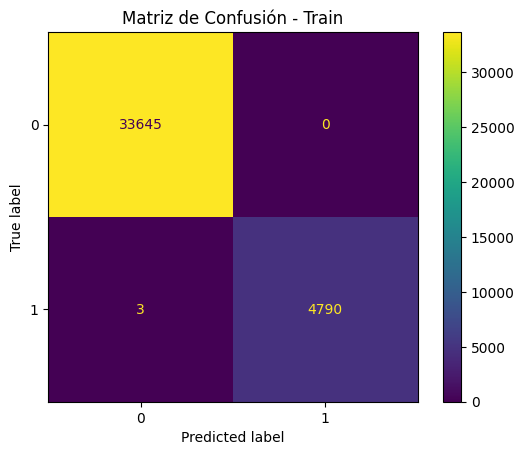

In [ ]:
# Visualización de la matriz de confusión
ConfusionMatrixDisplay(train_conf_matrix).plot()
plt.title("Matriz de Confusión - Train")
plt.show()

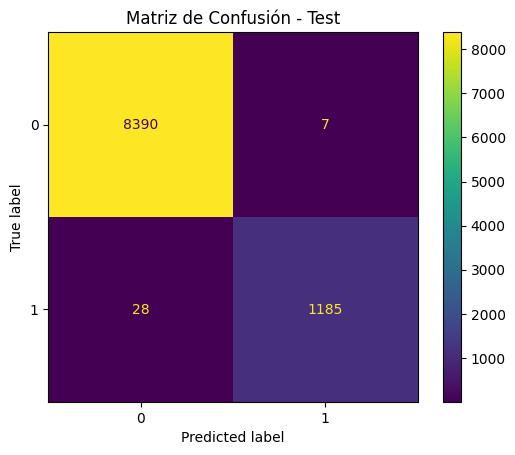

In [ ]:
ConfusionMatrixDisplay(test_conf_matrix).plot()
plt.title("Matriz de Confusión - Test")
plt.show()

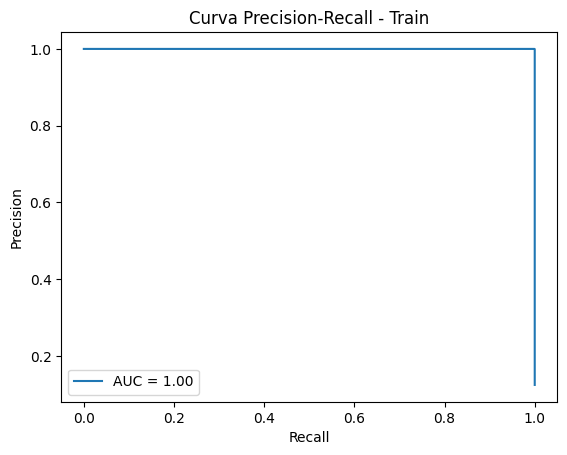

In [ ]:
# Curvas de Precision-Recall

# Para los datos de entrenamiento
y_train_scores = model.predict_proba(XtrainScaled)[:, 1]  # Puntajes para la clase positiva
precision_train, recall_train, _ = precision_recall_curve(y_target_train, y_train_scores)
pr_auc_train = auc(recall_train, precision_train)

plt.plot(recall_train, precision_train, label=f'AUC = {pr_auc_train:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Train')
plt.legend()
plt.show()

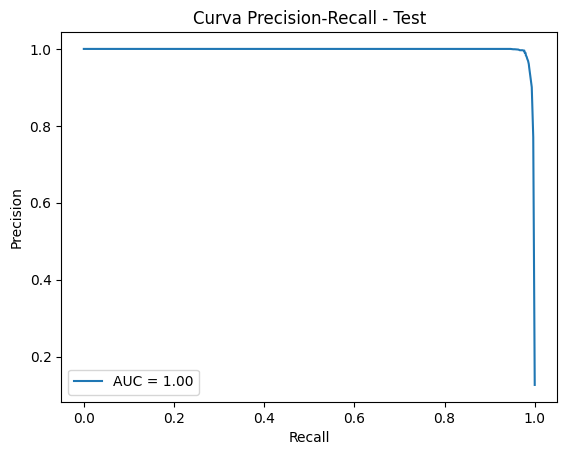

In [ ]:
# Para los datos de test
y_test_scores = model.predict_proba(XtestScaled)[:, 1]  # Puntajes para la clase positiva
precision_test, recall_test, _ = precision_recall_curve(y_target_test, y_test_scores)
pr_auc_test = auc(recall_test, precision_test)

plt.plot(recall_test, precision_test, label=f'AUC = {pr_auc_test:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Test')
plt.legend()
plt.show()

In [ ]:
# Obtener credenciales del entorno
creds, _ = google.auth.default()

In [ ]:
# Crear el servicio de Google Drive
drive_service = build('drive', 'v3', credentials=creds)

# Guardar el modelo localmente primero
model_filename = 'model_random_forest.pkl'
joblib.dump(model, model_filename)

# Especificar el ID de la carpeta
folder_id = '1wQv6lTixINg17x9E2JNhWoDO1fi7l4Xx'

# Especificar la ruta del archivo local
file_path = model_filename

# Crear un objeto de MediaFileUpload
media = MediaFileUpload(file_path, resumable=True)

# Crear un archivo en Google Drive
file_metadata = {
    'name': os.path.basename(file_path),  # Nombre del archivo en Google Drive
    'parents': [folder_id]  # ID de la carpeta donde se guardará el archivo
}

# Subir el archivo
uploaded_file = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()

print(f"File ID: {uploaded_file.get('id')}")
print(f"Model saved to shared Google Drive folder: https://drive.google.com/drive/folders/{folder_id}")


File ID: 1vyn8Z2N0kTwHefoYUrASdorXpK0YgJxW
Model saved to shared Google Drive folder: https://drive.google.com/drive/folders/1wQv6lTixINg17x9E2JNhWoDO1fi7l4Xx


In [ ]:
# Crear el servicio de Google Drive
drive_service = build('drive', 'v3', credentials=creds)

# Guardar el diccionario localmente primero
dict_filename = 'dict_model_results.pkl'
dict_results = {'names':names, 'results':results, 'models':fitted_models, 'X_test': XtestScaled, 'y_test': y_target_test}
joblib.dump(dict_results, dict_filename)

# Especificar el ID de la carpeta
folder_id = '1wQv6lTixINg17x9E2JNhWoDO1fi7l4Xx'

# Especificar la ruta del archivo local
file_path = dict_filename

# Crear un objeto de MediaFileUpload
media = MediaFileUpload(file_path, resumable=True)

# Crear un archivo en Google Drive
file_metadata = {
    'name': os.path.basename(file_path),  # Nombre del archivo en Google Drive
    'parents': [folder_id]  # ID de la carpeta donde se guardará el archivo
}

# Subir el archivo
uploaded_file = drive_service.files().create(
    body=file_metadata,
    media_body=media,
    fields='id'
).execute()

print(f"File ID: {uploaded_file.get('id')}")
print(f"Dictionary saved to shared Google Drive folder: https://drive.google.com/drive/folders/{folder_id}")


File ID: 1p9eF1Me4kzFi_xGrJ2dBrGsimcFb_1z3
Dictionary saved to shared Google Drive folder: https://drive.google.com/drive/folders/1wQv6lTixINg17x9E2JNhWoDO1fi7l4Xx
